## Learning to Rank with Linear Regression

In this notebook we load in the data set and train a linear regression model on the data. We then use this to rank data sets. 

In later notebooks we implement more sophisticated algorithms for Learning to Rank on the same data set. 

The data set we use here is the MSLR-WEB10K data set, which is open sourced by Mircosoft and can be downloaded from [here](https://www.microsoft.com/en-us/research/project/mslr/). We will only work with Fold1 of the data set. This notebook assumes that the contents of Fold1 are stored in a subdirectory named 'data'. If your data is stored elsewhere you will need to ammend the paths appropriately.

In [1]:
import pandas as pd

In [2]:
train = pd.read_csv("data/train.txt", header=None, sep=" ")

Let's inspect a sample of 5 rows from the data: 

In [3]:
import numpy as np

np.random.seed(0xc00f33e)
df_samp = train.sample(4)

In [4]:
df_samp

,0,1,2,3,4,5,6,7,8,9,...,129,130,131,132,133,134,135,136,137,138
84134,0,qid:10591,1:2,2:0,3:2,4:2,5:2,6:1,7:0,8:1,...,128:0,129:3,130:65142,131:55648,132:1,133:1,134:0,135:0,136:0,NaN
625314,2,qid:17722,1:0,2:2,3:0,4:0,5:2,6:0,7:0.50000,8:0,...,128:32,129:0,130:36833,131:50372,132:23,133:4,134:0,135:0,136:0,NaN
707552,1,qid:27727,1:1,2:0,3:1,4:0,5:1,6:1,7:0,8:1,...,128:3,129:2,130:620,131:16,132:25,133:126,134:0,135:0,136:0,NaN
458013,2,qid:26539,1:2,2:2,3:2,4:0,5:2,6:1,7:1,8:1,...,128:12,129:8,130:4682,131:51303,132:4,133:7,134:0,135:0,136:0,NaN


Each row represents a query - document pair. 

Column '0' is an integer taking values from 0 to 4, where 0 denotes "this document is irrelevant for this query", and 4 denotes "this document is perfectly relevant for this query".

Column '1' holds an integer identifying the query and is of the form 'qid:int'.

Columns '2' through to '137' hold the features for the query - document pair. The data in these columns are of the form 'feature_id:feature_value'. Full details about each of the features can be found here. 

Finally, column '138' is NaN for every row. (It is an artifact of the way we split the data set into columns.)

#### Processing the data

We want to do three things to the data frame in order to get it into an easier form to work with: 
1. replace 'qid:int' with 'int' in column '1'
2. replace 'feature_id:feature_value' with 'feature_value' for all entries in columns '2' to '137'
3. delete column '138'


In [5]:
def extract_qid(qid_str):
    return qid_str[4:]

def extract_val(feat):
    return feat.split(':')[1]


In [6]:
df_samp[1] = df_samp[1].apply(extract_qid)

df_samp[df_samp.columns[2:-1]] = df_samp[df_samp.columns[2:-1]].applymap(extract_val)
#applymap applies the function to every element of the data frame. 

#remove the last column. 
df_samp.drop( 138, axis = 1)

,0,1,2,3,4,5,6,7,8,9,...,128,129,130,131,132,133,134,135,136,137
84134,0,10591,2,0,2,2,2,1,0,1,...,33,0,3,65142,55648,1,1,0,0,0
625314,2,17722,0,2,0,0,2,0,0.50000,0,...,44,32,0,36833,50372,23,4,0,0,0
707552,1,27727,1,0,1,0,1,1,0,1,...,29,3,2,620,16,25,126,0,0,0
458013,2,26539,2,2,2,0,2,1,1,1,...,40,12,8,4682,51303,4,7,0,0,0


We wrap these transformations up in one function which we can then apply to the full training set. We also import and transform the testing set, which we will use to evaluate our model. 

In [7]:
def df_transform(df):
    df[1] = df[1].apply(extract_qid)
    df[df.columns[2:-1]] = df[df.columns[2:-1]].applymap(extract_val)
    df = df.drop(138, axis=1)
    return df

In [8]:
train_df = df_transform(train)

In [9]:
train_df.sample(3)

,0,1,2,3,4,5,6,7,8,9,...,128,129,130,131,132,133,134,135,136,137
542060,2,8167,2,0,2,1,2,1,0,1,...,43,3,7,9559,39270,14,5,0,0,0
120977,2,15121,2,1,1,1,2,1,0.50000,0.50000,...,57,9945,17,58604,60996,8,4,0,2405,99.6056888844168
396343,0,18904,0,0,0,0,0,0,0,0,...,21,0,0,154,799,134,72,0,0,0


In [10]:
test = pd.read_csv("data/test.txt", header=None, sep=" ")

In [11]:
test_df = df_transform(test)

In [12]:
X_test = test_df[test_df.columns[2:]]
y_test = test_df[0]

We can now go ahead and implement linear regression. We will use the features in columns '2' to '137' as the 'explanatory variables' to predict the relevence value, which is held in column '0'. 



In [13]:
import sklearn

In [14]:
from sklearn.linear_model import LinearRegression

In [15]:
X = train_df[train_df.columns[2:]]
y = train_df[0]

In [16]:
reg = LinearRegression().fit(X, y)

In [17]:
reg.score(X,y)

0.13349313112592232

We can make predictions for the test set. 

In [18]:
preds = reg.predict(X_test)

In [19]:
preds

array([0.76923034, 0.29349399, 0.3523804 , ..., 0.80657282, 0.43872805,
       0.19482099])

For now, we consider just the mean squared error between the predictions and the results. We use the metrics already in scikit learn to compute these. 

In [20]:
from sklearn.metrics import mean_squared_error

In [21]:
mean_squared_error(preds, y_test)

0.6055521003389398

## Visualisation

We plot the predicted score vs true score for the test set. 

In [22]:
plot_data = pd.concat([pd.DataFrame(y_test), pd.DataFrame(preds)], axis=1)
plot_data.columns = plot_data.columns.astype(str)

In [23]:
plot_data = pd.DataFrame(data= {"true score": y_test, "predicted score": preds})

In [24]:
plot_data.sample(10)

,true score,predicted score
217031,0,0.212263
191702,1,0.681021
110571,1,0.504319
1248,0,0.539843
227961,0,0.281012
42937,1,0.579672
194958,1,0.781614
115409,0,0.595637
129065,0,0.830366
198109,0,0.922282


/anaconda2/envs/ltr/lib/python3.7/site-packages/altair/utils/core.py:294: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  attrs['type'] = infer_vegalite_type(data[attrs['field']])


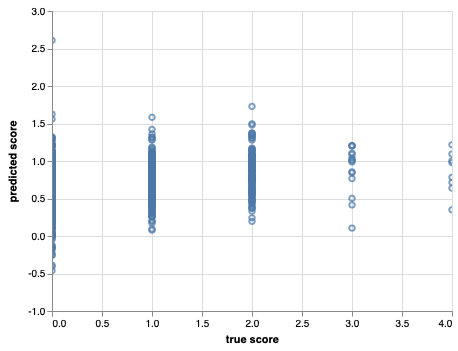

In [25]:
import altair as alt
alt.renderers.enable('notebook')

alt.Chart(plot_data.sample(1000)).encode(x="true score", y="predicted score").mark_point().interactive()

You can see that the true scores are discrete, not continuous, hence the vertical lines on the graph at the integer values 0 to 4. Predicted scores are clearly tending towards the sample mean  - no predictions above 2 are made, despite the data holding true scores of 3 and 4. 

In the next notebook we look at better ways to evaluate models.